In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'axes.labelsize': 16})
matplotlib.rcParams.update({'legend.fontsize': 16})
matplotlib.rcParams.update({'xtick.labelsize': 16,'ytick.labelsize': 16})
pd.options.display.float_format = '{:,.6f}'.format
cmap = plt.get_cmap("tab10")

# OD(x)=a/(1.0+exp(b*(x-MIC_x)))+c
def OD(x, a, b, c, MIC_x):
    return a/(1.0+np.exp(b*(x-MIC_x)))+c

def find_near_arg(ODdata):
    if ODdata.max()>0.25:
        OD_max = 0.25
    else:
        OD_max = ODdata.max()
        
    middle = 0.5*(OD_max+ODdata.min())
    mse = (ODdata-middle)**2
    MIC_can = np.argmin(mse) # candidate for MIC initial cond.
    return MIC_can

def plot_fitting_results(stress, day, strain_index, ODdata, optimal_param, rounded_mic, xdata, xxdata, savefig=True):
    plt.figure(figsize=(6,4))
    plt.scatter(xdata,ODdata,color=cmap(0))
    plt.plot(xxdata,OD(xxdata,*popt),color=cmap(1))
    plt.xlabel('well location')
    plt.ylabel('OD')
    plt.ylim(0.025,0.23)
    plt.title('Strain'+str(strain_index)+', stress = '+str(stress)+', MIC = well '
              +str(round(optimal_param[3],2))+' = '+str(rounded_mic)+' [log2($\mu$g/ml)]',fontsize=13)
    if savefig:
        plt.savefig('./OD_fitting/day'+str(day)+'_strain'+str(strain_index)+'_'+str(stress)+'.png',
                    dpi=100, bbox_inches='tight')
    plt.clf()
    plt.close()

In [38]:
# generate OD files for each strain

#getcwd = #~~Dropbox/Furusawa_experiment-data/EvolutionTrajectory/experiment_data/day1'
day = int(os.getcwd()[-1:])

stress_list = ['TET', 'KM', 'NFLX', 'SS', 'PLM', 'NQO', 'SDC', 'MMC']
well_col = np.arange(1,25)

try:
    os.mkdir('./reshaped_od/')
except FileExistsError:
    print('directory already existed')

for plate_num in range(1,31):
    
    datafile = pd.read_csv('./OD_data/OD_Result_'+f"{day:02d}"+'_'+f"{plate_num:02d}"+'.csv',
                           index_col=0,usecols=(3,5))
    datafile = datafile.iloc[:24*16,:]

    for i in range(2): # odd rows, even rows
        for stress_num in range(8): # TET, KM, NFLX, SS, PLM, NQO, SDC, MMC
            well_num = (2*stress_num+i)*24
            OD_data = datafile.iloc[well_num:well_num+24,:].T.values # OD values for (2*stress_num+i)+1 -th row
            
            if stress_num==0:
                full_OD_data = OD_data
            else:
                full_OD_data = np.append(full_OD_data,OD_data,axis=0)
                
        OD_df = pd.DataFrame(full_OD_data, index=stress_list, columns=well_col)
        OD_df.to_csv('./reshaped_od/OD_day'+str(day)+'_plate'+str(plate_num)+'_'+str(i+1)+'.csv')

file already existed


directory already existed
directory already existed


KeyboardInterrupt: 

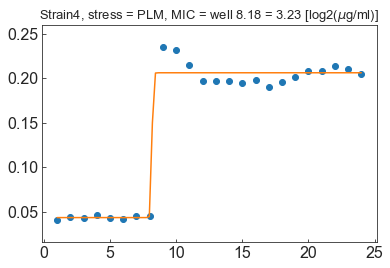

In [172]:
# fit all
try:
    os.mkdir('./OD_fitting/')
except FileExistsError:
    print('directory already existed')
try:
    os.mkdir('./Fitting_results/')
except FileExistsError:
    print('directory already existed')

for plate_num in range(1,31):
    for k in [1,2]:
        
        strain_index = 2*(plate_num-1)+k
        df = pd.read_csv('./reshaped_od/OD_day'+str(day)+'_plate'+str(plate_num)+'_'+str(k)+'.csv',index_col=0)
        plate_info = pd.read_excel('./../PlateType_matching_30plates.xlsx',index_col=0)
        plate_type = plate_info.loc[plate_num].values[0]
        conc_info = pd.read_excel('./../conc_data/Plate'+str(plate_type)+'.xlsx',index_col=0)

        mic_data_8d = np.zeros((8,1)) # 8-dim. vector of IC50 data
        xdata = np.linspace(1,24,24)
        xxdata=np.linspace(1,24,100)
        
        for i,stress in enumerate(stress_list):

            ODdata = df.loc[stress].values
            max_conc = conc_info.loc[stress]['MaxConc_ug_per_ml']
            step_size = conc_info.loc[stress]['step_size']

            MIC_can = find_near_arg(ODdata)
            if (MIC_can<2)+(MIC_can>23):
                MIC_can = 12

            try:
                popt, pcov = curve_fit(OD, xdata, ODdata, p0=[0.25, -2, 0.038, MIC_can],
                                      bounds=([0.04, -60, 0, 2], [0.3, -0.4, 0.1, 23]))
                log2_MIC = np.log2(max_conc)-(popt[3]-2)*step_size #[log2(μg/ml)]
                rounded_mic = round(log2_MIC,2)

                mic_data_8d[i,0] = log2_MIC 

                plot_fitting_results(stress, day, strain_index, ODdata, popt, 
                                     rounded_mic, xdata, xxdata, 
                                     savefig=True)
            except RuntimeError:
                mic_data_8d[i,0] = float('nan')
        if strain_index == 1:
            MIC8d_df = pd.DataFrame(mic_data_8d,index=stress_list,columns=['strain'+str(strain_index)])
        else:
            MIC8d_df['strain'+str(strain_index)] = mic_data_8d
        
MIC8d_df.to_csv('./Fitting_results/day'+str(day)+'_all_strains.csv')
MIC8d_df.to_csv('./Fitting_results/day'+str(day)+'_all_strains_corrected.csv')

directory already existed


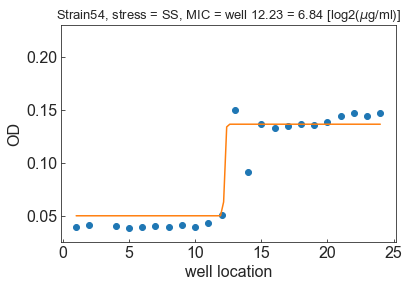

In [14]:
# amending fitting results that were not appropriate
strain_index = 54
stress = 'SS'
day = int(os.getcwd()[-1:])
# 'TET', 'KM', 'NFLX', 'SS', 'PLM', 'NQO', 'SDC', 'MMC'

result_df = pd.read_csv('./Fitting_results/day'+str(day)+'_all_strains_corrected.csv', index_col=0)

k = strain_index%2
plate_num = int((strain_index+k)/2)
if k ==0:
    k=2
    
try:
    os.mkdir('./OD_fitting/corrected_fitting/')
except FileExistsError:
    print('directory already existed')

df = pd.read_csv('./reshaped_od/OD_day'+str(day)+'_plate'+str(plate_num)+'_'+str(k)+'.csv',index_col=0)
plate_info = pd.read_excel('./../PlateType_matching_30plates.xlsx',index_col=0)
plate_type = plate_info.loc[plate_num].values[0]
conc_info = pd.read_excel('./../conc_data/Plate'+str(plate_type)+'.xlsx',index_col=0)

xdata = np.linspace(1,24,24)
xxdata=np.linspace(1,24,100)

ODdata = df.loc[stress].values
max_conc = conc_info.loc[stress]['MaxConc_ug_per_ml']
step_size = conc_info.loc[stress]['step_size']

MIC_can = find_near_arg(ODdata)
if (MIC_can<2)+(MIC_can>23):
    MIC_can = 12
MIC_can=10
    
try:
    popt, pcov = curve_fit(OD, xdata, ODdata, p0=[0.25, -20, 0.038, MIC_can],
                          bounds=([0.04, -60, 0, 2], [0.3, -2, 0.05, 23]))
    log2_MIC = np.log2(max_conc)-(popt[3]-2)*step_size #[log2(μg/ml)]
    rounded_mic = round(log2_MIC,2)

    result_df.loc[stress].iloc[strain_index-1] = log2_MIC 

    plt.figure(figsize=(6,4))
    plt.scatter(xdata,ODdata,color=cmap(0))
    plt.plot(xxdata,OD(xxdata,*popt),color=cmap(1))
    plt.xlabel('well location')
    plt.ylabel('OD')
    plt.ylim(0.025,0.23)
    plt.title('Strain'+str(strain_index)+', stress = '+str(stress)+', MIC = well '
              +str(round(popt[3],2))+' = '+str(rounded_mic)+' [log2($\mu$g/ml)]',fontsize=13)
    plt.savefig('./OD_fitting/corrected_fitting/day'+str(day)+'_strain'+str(strain_index)+'_'+str(stress)+'.png',
                dpi=100, bbox_inches='tight')
    plt.show()
    result_df.to_csv('./Fitting_results/day'+str(day)+'_all_strains_corrected.csv')
except RuntimeError:
    result_df.loc[stress].iloc[strain_index-1] = float('nan')
    plt.figure(figsize=(6,4))
    plt.scatter(xdata,ODdata,color=cmap(0))
    plt.xlabel('well location')
    plt.ylabel('OD')
    plt.ylim(0.025,0.23)

In [5]:
# check if there are any NaNs in the fitting results
day = int(os.getcwd()[-1:])

result_df = pd.read_csv('./Fitting_results/day'+str(day)+'_all_strains_corrected.csv', index_col=0)
result_df.isnull().sum().sum()

0